In [1]:
!pip install torch torchvision torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 16


In [4]:
# trasform - download data - dataloader

transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
])

transform_target = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    transform = transform,
    target_transform = transform_target,
    download=True,
    )

test_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data',
    split='test',
    target_types='segmentation',
    transform=transform,
    target_transform = transform_target,
    download=True,
    )


# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 791918971/791918971 [00:37<00:00, 20882953.79it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 9405212.51it/s] 


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [5]:
# model U-NET
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [6]:
# loss and opt

# CE / Focal Loss (better for unlances dataset) / IoU Loss (Jaccard)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# training loop

model.train()
for epoch in range(num_epochs):
    for idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # forward
        output = model(image)

        # loss - backward - op
        label = label*255 # to remove the ToTensor operation
        label = (label==1).float() # 1 foreground all the other points are back
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')




Epoch [1/10], Step [100/230], Loss: 0.5784
Epoch [1/10], Step [200/230], Loss: 0.6165
Epoch [2/10], Step [100/230], Loss: 0.5863
Epoch [2/10], Step [200/230], Loss: 0.6046
Epoch [3/10], Step [100/230], Loss: 0.6010
Epoch [3/10], Step [200/230], Loss: 0.6018
Epoch [4/10], Step [100/230], Loss: 0.6092
Epoch [4/10], Step [200/230], Loss: 0.5840
Epoch [5/10], Step [100/230], Loss: 0.5888
Epoch [5/10], Step [200/230], Loss: 0.5907
Epoch [6/10], Step [100/230], Loss: 0.5943
Epoch [6/10], Step [200/230], Loss: 0.6022


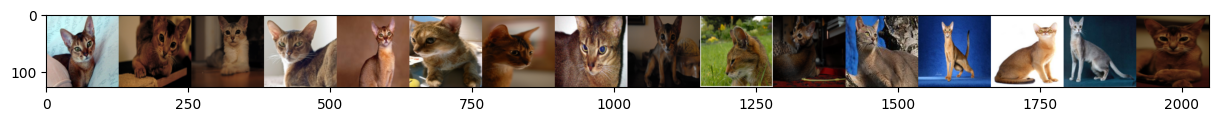

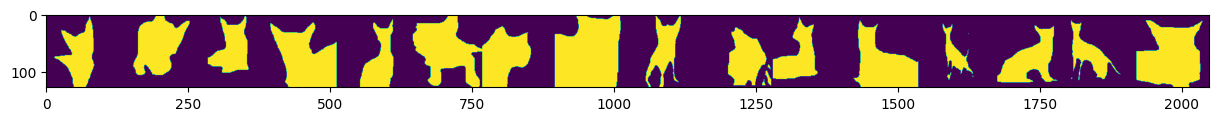

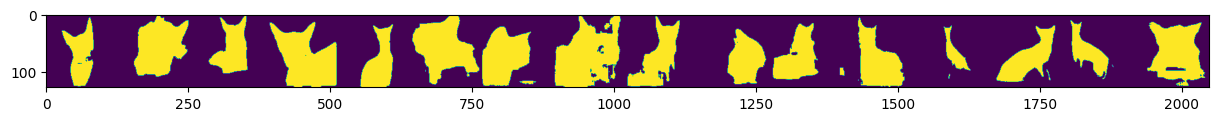

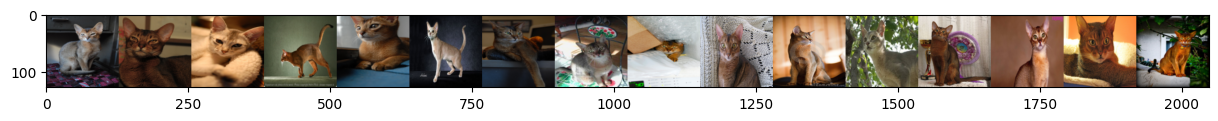

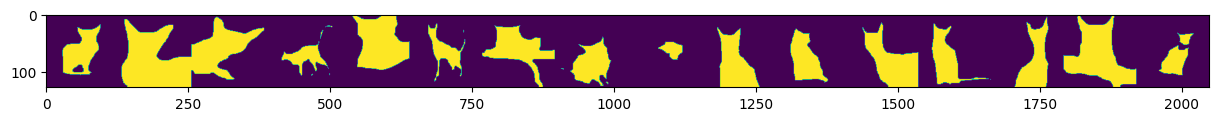

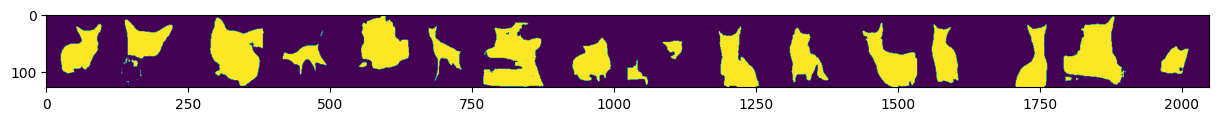

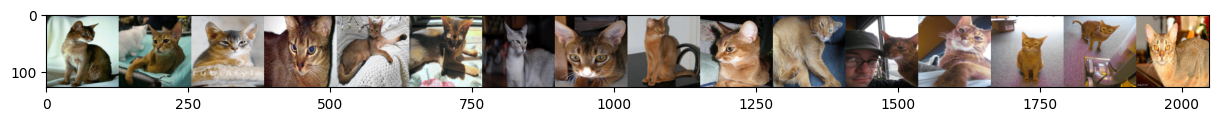

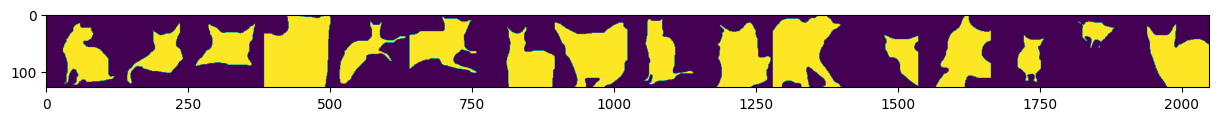

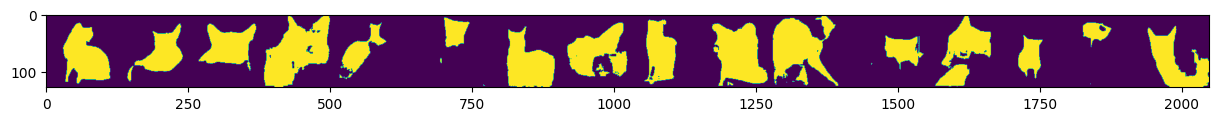

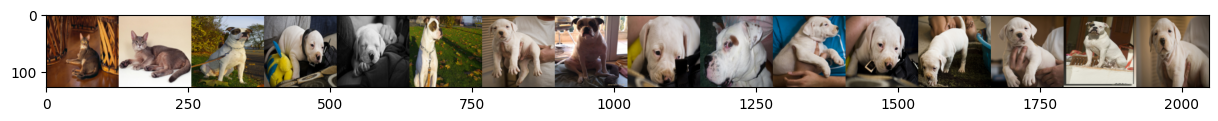

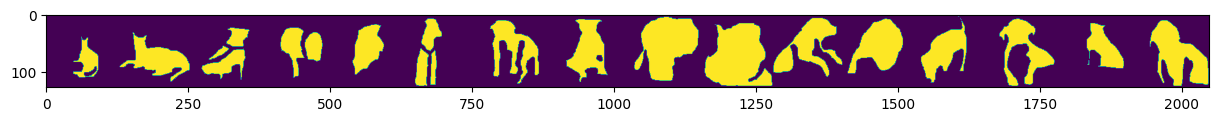

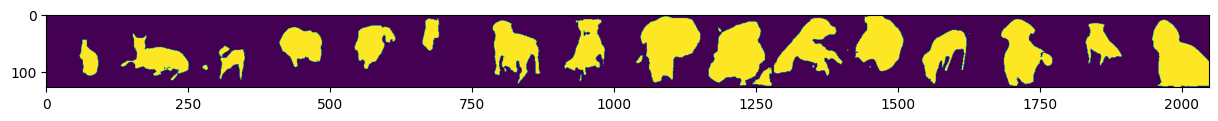

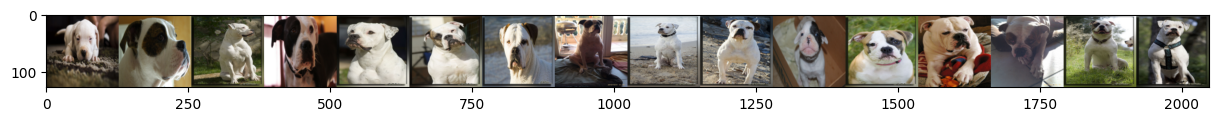

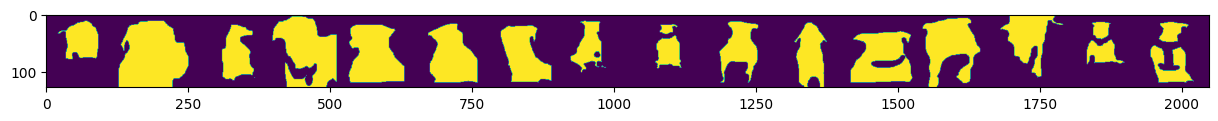

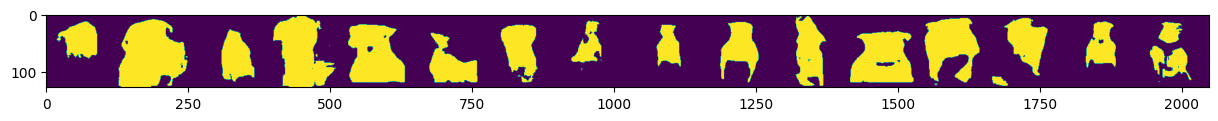

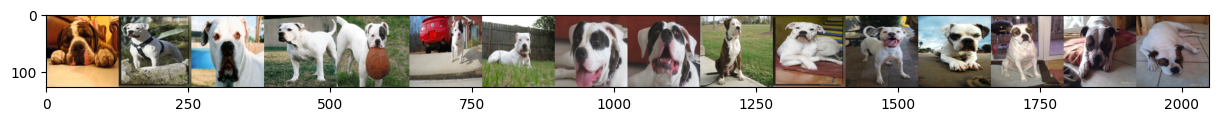

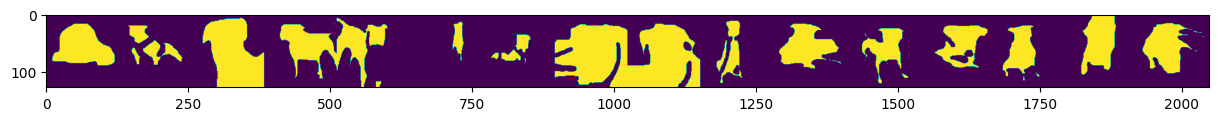

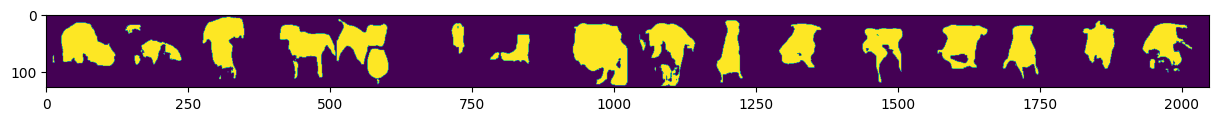

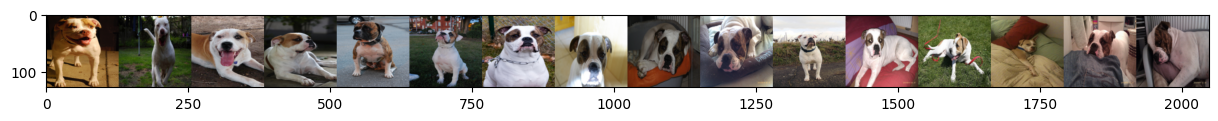

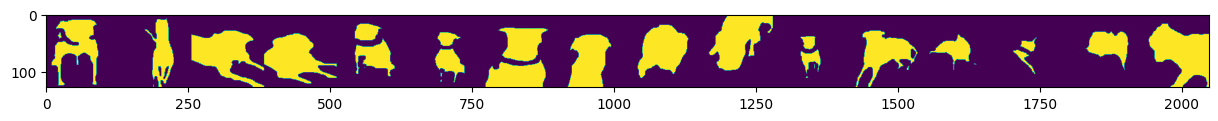

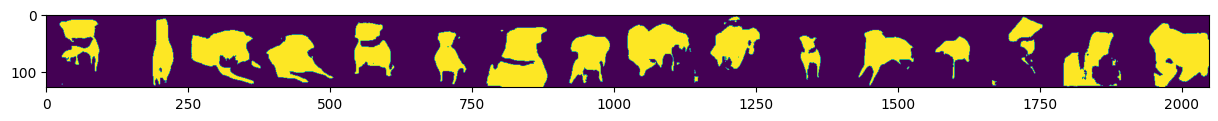

Accuracy on the test set: 92.91%
IoU on the test set: 0.77%
IoU by me on the test set: 0.77%


In [26]:
from sklearn.metrics import jaccard_score
from torchmetrics.classification import BinaryJaccardIndex

import matplotlib.pyplot as plt
import numpy as np
# eval

# accuracy / IoU / mAP

model.eval()
IoU = 0
IoU_by_me = 0
n_batch = 0
metric = BinaryJaccardIndex( )
with torch.no_grad():
    correct = 0
    total = 0
    for idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        labels = labels*255
        labels = (labels==1).float()

        outputs = (outputs > 0.5).float()
        bs, c, h , w = labels.size()
        n_batch += 1
        IoU += jaccard_score(labels.view(-1).cpu().numpy().reshape(-1), outputs.view(-1).cpu().numpy().reshape(-1),average='binary')

        total += bs*h*w*c
        correct += (outputs == labels).sum().item()

        union = ((outputs + labels) >= 1).float().sum()
        inters = (outputs * labels).float().sum()

        union = torch.logical_or(outputs.reshape(-1), labels.reshape(-1)).float().sum()
        inters = torch.logical_and(outputs.reshape(-1), labels.reshape(-1)).float().sum()

        IoU_by_me += abs(inters)/abs(union)

        assert (abs(inters)/abs(union)) <= 1

        # to visualize IMG / GT / Prediction
        if idx > 2 and idx < 10 :
            img = images.permute(0,2,3,1)

            img = np.concatenate(img.cpu().numpy(), axis=1)
            fig = plt.figure(figsize=(15, 10))
            plt.imshow(img)
            plt.show()

            img = labels.permute(0,2,3,1)
            img = np.concatenate(img.cpu().numpy(), axis=1)
            fig = plt.figure(figsize=(15, 10))
            plt.imshow(img)
            plt.show()

            img = outputs.permute(0,2,3,1)
            img = np.concatenate(img.cpu().numpy(), axis=1)
            fig = plt.figure(figsize=(15, 10))
            plt.imshow(img)
            plt.show()

accuracy = correct / total
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')
IoU = IoU / n_batch
print(f'IoU on the test set: {IoU:.2f}%')

IoU_by_me = IoU_by_me / n_batch
print(f'IoU by me on the test set: {IoU_by_me:.2f}%')
